<a href="https://colab.research.google.com/github/sonpn82/Tensor-flow-Developer-Certification-Exam/blob/main/08_introduction_to_nlp_in_tensorflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

In [1]:
## Check for GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-21 00:55:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-21 00:55:40 (65.6 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [3]:
# Import series of helper functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster)

See the original source here:" https://www.kaggle.com/datasets/vstepanenko/disaster-tweets

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2022-07-21 00:55:50--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 172.253.123.128, 142.250.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.2’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2022-07-21 00:55:50 (124 MB/s) - ‘nlp_getting_started.zip.2’ saved [607343/607343]



In [5]:
# unzip data
unzip_data("nlp_getting_started.zip")

## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [6]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [8]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=24)
train_df_shuffled.head()

,id,keyword,location,text,target
3068,4402,electrocute,NaN,Kids got Disney version of the game Operation ...,0
3148,4522,emergency,"Indianapolis, IN",UPDATE: Indiana State Police reopening I-65 ne...,1
3139,4511,emergency,Phoenix,God forbid anyone in my family knows how to an...,0
7485,10707,wreck,"Alabama, USA",First wreck today. So so glad me and mom are o...,0
6023,8608,seismic,Somalia,Exploration takes seismic shift in Gabon to So...,0


In [9]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [11]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [12]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
@Whippenz We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

---

Target: 0 (not real disaster)
Text:
@GloriaVelez GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings

---

Target: 0 (not real disaster)
Text:
Louis Vuitton Monogram Sophie Limited Edition Clutch Cross body Bag - Full read by eBay http://t.co/GGgFVO5Pb4 http://t.co/NlFr8t3xqm

---

Target: 0 (not real disaster)
Text:
@Memenaar But the design decision to 'Let's make something fresh and beautiful and wonderful and then WRECK IT' is kindof odd in restrospect

---

Target: 1 (real disaster)
Text:
Property losses from #California wildfire nearly double as week-old blaze rages: The fireÛ_ http://t.co/MsdizftZ2g

---



### Split data into training and validation sets

In [13]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into train and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,  # use 10% of training data for validation
                                                                            random_state=24)

In [14]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [15]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@Jake_ADavis @FaTality_US we are cuddling right now so.. ??',
        'National Briefing | West: California: Spring Oil Spill Estimate Grows: Documents released on Wednesday disclos... http://t.co/wBi7Laq18E',
        'We have different moral systems. Mine rejects the mass murder of innocents yours explicitly endorses such behavior. https://t.co/qadRKEJZ9T',
        'Some of worst radiation exposure from Fukushima meltdown happened 47km northwest-Proof that small emergency planning zones don\x89Ûªt cut it',
        'Corey Robinson having some solid reps at RT although as I type this he got beat on lightning dip by T. Walker',
        'Evacuation order lifted for Roosevelt after #Wildfire misses town - KOMO News http://t.co/qCpMktGLLR',
        'Property losses from California wildfire nearly double as week-old blaze rages http://t.co/E0UUsnpsq5',
        'Please sign &amp; RT to save #SaltRiverWildHorses http://t.co/IKUAYUSEqt http://t.co/BQBHUyfmE9',
        "@awadgolf @GOP a

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [16]:
train_sentences[:5]

array(['@Jake_ADavis @FaTality_US we are cuddling right now so.. ??',
       'National Briefing | West: California: Spring Oil Spill Estimate Grows: Documents released on Wednesday disclos... http://t.co/wBi7Laq18E',
       'We have different moral systems. Mine rejects the mass murder of innocents yours explicitly endorses such behavior. https://t.co/qadRKEJZ9T',
       'Some of worst radiation exposure from Fukushima meltdown happened 47km northwest-Proof that small emergency planning zones don\x89Ûªt cut it',
       'Corey Robinson having some solid reps at RT although as I type this he got beat on lightning dip by T. Walker'],
      dtype=object)

In [17]:
import tensorflow as tf
from tensorflow.keras.layers  import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000,  # How many words in the vocabulary - none  no limit
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,   # Create groups of n-words
                                    output_mode="int",  # how to map tokens to number
                                    output_sequence_length=None,   # None: automatic pad each text sequence to be equal to the longest sequence  (all sequence must be same size for input)
                                    pad_to_max_tokens=True)

In [18]:
len(train_sentences[0].split())

9

In [19]:
# Find the average number of tokens (words) in the training tweet
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [20]:
# Setup text vectorization variables
max_vocab_length = 10000  # max number of words to have in our vocabulary
max_length = 15  # max length of our sequences will be  (how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [21]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [22]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in  my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[276,   3, 218,   4,  13, 730,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[2873, 4178, 4302,  203,    6,  553, 1397, 5365,    0,    0,    0,
           0,    0,    0,    0]])>

In [24]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()  
top_5_words = words_in_vocab[:5]  # Get the most common words
bottom_5_words = words_in_vocab[-5:]  # Get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pact', 'pacquiao', 'packåÊfor', 'packed', 'packages']


[UNK] = unknown words  - due to limit setting in vocabulary (10000). With bigger vocab, unknown words number will be reduced.

### Creating an Embedding using and Embedding layer

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embeddig vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [25]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,  # set input shape
                             output_dim=128,  # output shape
                             input_length=max_length)  # how long is each input

embedding                             

In [26]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vector of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 #greatbritishbakeoff love to know where I was when all this nice weather happened! Did miss the heat wave ?? ??      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01384852,  0.01825477,  0.04542768, ..., -0.03750779,
         -0.00978516,  0.04919174],
        [-0.0034436 ,  0.0240322 , -0.02581791, ...,  0.02746601,
          0.00364035, -0.04396259],
        [ 0.00826559,  0.04549268, -0.04666879, ...,  0.00485916,
          0.02192874, -0.04713328],
        ...,
        [-0.01534881,  0.03486102,  0.01508209, ...,  0.00902953,
          0.03965114, -0.00458084],
        [ 0.02915789, -0.02662058,  0.02227918, ..., -0.04262019,
          0.02929198,  0.03356699],
        [-0.03940905,  0.0411326 , -0.00680804, ...,  0.0261045 ,
         -0.02838485,  0.04676961]]], dtype=float32)>

In [27]:
# Check out a single token embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 1.38485171e-02,  1.82547681e-02,  4.54276837e-02, -2.50697266e-02,
         2.08973326e-02, -4.12596948e-02, -6.03619963e-03,  6.04601949e-03,
        -2.58335471e-02,  1.36209652e-03, -3.80723961e-02, -1.74252614e-02,
         4.76845838e-02, -1.50362961e-02,  2.29310431e-02,  3.19696702e-02,
         3.45346220e-02,  8.40798020e-05,  1.91590227e-02, -1.19874477e-02,
        -4.87654582e-02, -1.07635483e-02, -1.45453326e-02,  1.82353333e-03,
        -6.28840923e-03, -3.34191471e-02,  2.93683521e-02, -1.82664394e-02,
        -3.33890468e-02,  1.01141557e-02,  4.31381352e-02, -6.05751202e-03,
        -4.40189354e-02,  1.19935758e-02, -4.10898440e-02,  7.06489012e-03,
         3.09306271e-02,  3.68507765e-02, -4.40651439e-02,  3.75454910e-02,
         4.49502133e-02,  3.87438200e-02,  2.18680240e-02, -4.89345789e-02,
        -4.38146666e-03,  2.13076808e-02,  4.08235937e-03, -4.95040789e-02,
        -1.08010285e-02, -2.64225006e-0

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers,
it's time to start buiding a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline) - from scikit-learn: https://scikit-learn.org/stable/tutorial/machine_learning_map/
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data.

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> **Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),  # convert words to numbers using tfidf
                    ("clf", MultinomialNB())  # Model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
# Evaluate our model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of:{baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of:78.35%


In [30]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictios with different metrics every time, however, this will be calculated with a function...

Let's create one to compare our model's predictions with the truth labels using the following metrics:
- Accuracy
- Precision
- Recall
- F1-score

For a deep overview of many different evaluation methods, see the Sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [28]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}

  return model_results                

In [32]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 78.34645669291339,
 'f1': 0.7750816117942654,
 'precision': 0.8028871176572036,
 'recall': 0.7834645669291339}

### Model 1: A simple dense model

In [29]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [34]:
# Build model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs)  # turn the input text into number
x = embedding(x)  # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x)  # Lower the dimensionality of the embedding layer
outputs = layers.Dense(1, activation="sigmoid")(x)  # Create the output layer
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [35]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [36]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [37]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220719-231639
Epoch 1/5
215/215 [==============================] - 8s 27ms/step - loss: 0.6121 - accuracy: 0.6911 - val_loss: 0.5360 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 7s 31ms/step - loss: 0.4438 - accuracy: 0.8167 - val_loss: 0.4671 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 7s 30ms/step - loss: 0.3502 - accuracy: 0.8605 - val_loss: 0.4536 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 0.2878 - accuracy: 0.8875 - val_loss: 0.4607 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2413 - accuracy: 0.9067 - val_loss: 0.4768 - val_accuracy: 0.7756


In [38]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 0.4768 - accuracy: 0.7756


[0.4767865836620331, 0.7755905389785767]

In [39]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

array([[0.02990872],
       [0.21891329],
       [0.4145953 ],
       [0.3782246 ],
       [0.16324103],
       [0.99391973],
       [0.0277648 ],
       [0.351138  ],
       [0.07447702],
       [0.78607476]], dtype=float32)

In [40]:
model_1_pred_probs.shape

(762, 1)

In [41]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 1., 0.], dtype=float32)>

In [42]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.55905511811024,
 'f1': 0.7742955659048012,
 'precision': 0.7752939550126888,
 'recall': 0.7755905511811023}

In [43]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [44]:
# Get the vocabulary from the text vectorization
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [46]:
# Get hte weight matrix of embedding layer
# (these are numerical representation of each token in our training data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights

array([[-0.0226278 , -0.00929556,  0.01725918, ...,  0.06067792,
        -0.04536456,  0.00771817],
       [ 0.04816829,  0.00475889,  0.01498136, ...,  0.00277412,
        -0.02974758,  0.02107029],
       [-0.02420579, -0.05329626, -0.03431385, ..., -0.00076147,
        -0.01107265,  0.00864148],
       ...,
       [-0.01007806, -0.0389666 , -0.06858771, ...,  0.01998283,
         0.0137863 , -0.05307138],
       [-0.05537574,  0.04941653,  0.05821885, ..., -0.03244834,
        -0.07961819,  0.03930553],
       [ 0.04512035,  0.01034484, -0.04740353, ..., -0.01054499,
         0.02439178, -0.01350746]], dtype=float32)

In [47]:
print(embed_weights.shape)  # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/
And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [48]:
# Create embedding files (we got this from TensorFlow's word embedding doucmentation)
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [49]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural netwokr is to use the representation of a previous input to aid the representation of a later input.

If you want an overview of the internals of a recurrent neural network, see the following:
- https://www.youtube.com/watch?v=SEnXr6v2ifU&t=74s
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (Label probability)
```

In [50]:
# Create an LSTM mdoel
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.LSTM(units=64, return_sequences=True)(x)  # set return_sequences=True keep the "15" dimensions at output 15, 128 => 15,64, if not then can not stack to another LSTM after that
x = layers.LSTM(units=64)(x)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [51]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [52]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [53]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220719-231717
Epoch 1/5
215/215 [==============================] - 12s 37ms/step - loss: 0.2268 - accuracy: 0.9177 - val_loss: 0.5132 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 7s 33ms/step - loss: 0.1565 - accuracy: 0.9428 - val_loss: 0.6820 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 7s 34ms/step - loss: 0.1296 - accuracy: 0.9527 - val_loss: 0.6724 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 10s 45ms/step - loss: 0.1028 - accuracy: 0.9628 - val_loss: 0.7814 - val_accuracy: 0.7533
Epoch 5/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0855 - accuracy: 0.9648 - val_loss: 0.8471 - val_accuracy: 0.7625


In [54]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[0.00309482],
       [0.05785179],
       [0.03211036],
       [0.8209919 ],
       [0.02974921],
       [0.9998622 ],
       [0.00330645],
       [0.3909907 ],
       [0.01156983],
       [0.8930043 ]], dtype=float32)

In [55]:
# Convert model2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 1., 0., 0., 0., 1.], dtype=float32)>

In [56]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.24671916010499,
 'f1': 0.7610964761916317,
 'precision': 0.7619777536015249,
 'recall': 0.7624671916010499}

Accuracy is still lower than baseline model!

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [57]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.GRU(64, return_sequences=True)(x)  # return_sequence=True so we can stack recurrent layers on top of each  other
#x = layers.LSTM(64, return_sequences=True)(x)
#x = layers.GRU(64)(x)
#x = layers.Dense(64, activation="relu")(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [58]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [59]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [60]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220719-231804
Epoch 1/5
215/215 [==============================] - 14s 44ms/step - loss: 0.1672 - accuracy: 0.9348 - val_loss: 0.7387 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0847 - accuracy: 0.9711 - val_loss: 0.8351 - val_accuracy: 0.7520
Epoch 3/5
215/215 [==============================] - 8s 40ms/step - loss: 0.0735 - accuracy: 0.9733 - val_loss: 0.9177 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 7s 35ms/step - loss: 0.0617 - accuracy: 0.9756 - val_loss: 1.0608 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0519 - accuracy: 0.9771 - val_loss: 1.3853 - val_accuracy: 0.7480


In [61]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[2.4440885e-04],
       [7.0291758e-04],
       [6.6852570e-04],
       [9.9822170e-01],
       [8.2594156e-04],
       [9.9988145e-01],
       [2.8401613e-04],
       [2.8854597e-01],
       [3.3897758e-03],
       [9.9890757e-01]], dtype=float32)

In [62]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 1., 0., 0., 0., 1.], dtype=float32)>

In [63]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 74.80314960629921,
 'f1': 0.7476172829115483,
 'precision': 0.7474627376162521,
 'recall': 0.7480314960629921}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence). However, a bidirectional RNN goes from right to left as well as left to right.


In [64]:
# Build a bidirectional RNN in tensorflow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [65]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              74496     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,354,625
Trainable params: 1,3

In [66]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [67]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220719-231852
Epoch 1/5
215/215 [==============================] - 22s 64ms/step - loss: 0.1275 - accuracy: 0.9550 - val_loss: 0.9298 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0607 - accuracy: 0.9774 - val_loss: 1.1833 - val_accuracy: 0.7585
Epoch 3/5
215/215 [==============================] - 10s 45ms/step - loss: 0.0517 - accuracy: 0.9787 - val_loss: 1.2635 - val_accuracy: 0.7546
Epoch 4/5
215/215 [==============================] - 10s 47ms/step - loss: 0.0491 - accuracy: 0.9796 - val_loss: 1.1972 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 11s 50ms/step - loss: 0.0444 - accuracy: 0.9793 - val_loss: 1.4898 - val_accuracy: 0.7546


In [68]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[3.1324085e-05],
       [4.0128827e-04],
       [1.6975403e-04],
       [9.9962640e-01],
       [1.7915368e-03],
       [9.9998939e-01],
       [5.2756179e-05],
       [9.8436308e-01],
       [2.5486946e-04],
       [9.9927723e-01]], dtype=float32)

In [69]:
# Convert pred_probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 1., 0., 1., 0., 1.], dtype=float32)>

In [70]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 75.45931758530183,
 'f1': 0.753532122621304,
 'precision': 0.753866724115352,
 'recall': 0.7545931758530183}

## Convolution Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we've Conv2D for our image data but now we're going to use Conv1D.

The typcial structure of a Conv1D mdoel for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

For different explainations of parameters see:
* http://poloclub.github.io/cnn-explainer/

Difference between "same" and valid paddings:
* https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t


In [71]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))  
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,  # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        activation="relu",
                        padding="valid") # default = valid, the output is smaller than the input shape, same means output is equal to input shape
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)  # get the most important feature or get the feature with the highest value

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [72]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01379767, -0.07883656, -0.08159502, ...,  0.08454976,
          0.01984275,  0.01600166],
        [ 0.0225145 ,  0.00818272,  0.03922267, ...,  0.01747886,
          0.04787241,  0.02199406],
        [ 0.06255584,  0.08384563,  0.06648956, ...,  0.04702742,
          0.02098147,  0.04778607],
        ...,
        [-0.00808891, -0.01308873,  0.01324397, ...,  0.02607142,
         -0.01432648,  0.00299355],
        [-0.00808891, -0.01308873,  0.01324397, ...,  0.02607142,
         -0.01432648,  0.00299355],
        [-0.00808891, -0.01308873,  0.01324397, ...,  0.02607142,
         -0.01432648,  0.00299355]]], dtype=float32)>

In [73]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.03684227, 0.        , 0.        , 0.01774   , 0.0866352 ,
         0.        , 0.01978245, 0.        , 0.00299646, 0.        ,
         0.02485899, 0.        , 0.0358817 , 0.05513297, 0.        ,
         0.07196901, 0.00614361, 0.01675974, 0.        , 0.        ,
         0.04668758, 0.        , 0.02168195, 0.00881136, 0.        ,
         0.01432932, 0.05441204, 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.01039257, 0.07147349, 0.0043753 , 0.01209882,
         0.        , 0.        , 0.0839862 , 0.02660772, 0.        ,
         0.00785246, 0.03058786, 0.        , 0.        , 0.00994075,
         0.0202462 , 0.        , 0.        , 0.        , 0.01734976,
         0.00551574, 0.        , 0.00169195, 0.        , 0.12879138,
         0.06091878, 0.        , 0.0378528 , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.    

In [74]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.03684227, 0.02297052, 0.07147349, 0.02210067, 0.09227861,
        0.013376  , 0.03568691, 0.0839862 , 0.02660772, 0.08359827,
        0.09032141, 0.04278914, 0.0358817 , 0.05991467, 0.00994075,
        0.07196901, 0.04509404, 0.02955586, 0.04420366, 0.01734976,
        0.04668758, 0.02528239, 0.04891644, 0.00881136, 0.12879138,
        0.06091878, 0.05441204, 0.06096985, 0.07345955, 0.02747756,
        0.01048835, 0.03650092]], dtype=float32)>

In [75]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, 
                  kernel_size=5,
                  activation="relu",
                  padding="valid",
                  )(x)
x = layers.GlobalMaxPool1D()(x)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get the summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [76]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20220719-231955
Epoch 1/5
215/215 [==============================] - 8s 31ms/step - loss: 0.1240 - accuracy: 0.9584 - val_loss: 1.0008 - val_accuracy: 0.7428
Epoch 2/5
215/215 [==============================] - 6s 30ms/step - loss: 0.0729 - accuracy: 0.9730 - val_loss: 1.1049 - val_accuracy: 0.7441
Epoch 3/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0598 - accuracy: 0.9781 - val_loss: 1.2523 - val_accuracy: 0.7441
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0522 - accuracy: 0.9793 - val_loss: 1.3533 - val_accuracy: 0.7441
Epoch 5/5
215/215 [==============================] - 7s 30ms/step - loss: 0.0523 - accuracy: 0.9801 - val_loss: 1.3871 - val_accuracy: 0.7336


In [77]:
# Make some predictions with our Conv1D
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[2.1291024e-05],
       [1.0959804e-02],
       [2.2159219e-03],
       [9.9919164e-01],
       [9.7876787e-04],
       [9.9999917e-01],
       [5.0587255e-06],
       [3.1588596e-01],
       [4.8996540e-06],
       [9.1333580e-01]], dtype=float32)

In [78]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 1., 0., 0., 0., 1.], dtype=float32)>

In [79]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 73.35958005249343,
 'f1': 0.7329027724310093,
 'precision': 0.7327834971922269,
 'recall': 0.7335958005249343}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specially using TensorFlow Hub's Universal Sentence
Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

Paper: https://arxiv.org/abs/1803.11175

In [80]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,"When you can the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [81]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157025,  0.02485911,  0.02878051, ..., -0.00186124,
         0.02315822, -0.01485021],
       [ 0.03485873, -0.08845595, -0.01677879, ..., -0.02750709,
         0.03230235, -0.00820085]], dtype=float32)>

In [82]:
# Create a Keras layers using the USE pretrained layer from tensorflow_hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [83]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")                               
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [84]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220719-232100
Epoch 1/5
215/215 [==============================] - 8s 20ms/step - loss: 0.5040 - accuracy: 0.7888 - val_loss: 0.4595 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4148 - accuracy: 0.8168 - val_loss: 0.4477 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4001 - accuracy: 0.8234 - val_loss: 0.4381 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3921 - accuracy: 0.8295 - val_loss: 0.4399 - val_accuracy: 0.7940
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3839 - accuracy: 0.8300 - val_loss: 0.4379 - val_accuracy: 0.7966


In [85]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.40316987],
       [0.37650388],
       [0.14951316],
       [0.17935833],
       [0.10580739],
       [0.94714534],
       [0.04520392],
       [0.06449658],
       [0.11625919],
       [0.96592283]], dtype=float32)

In [86]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=float32)>

In [87]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 79.65879265091863,
 'f1': 0.7942331441856619,
 'precision': 0.7987320349567643,
 'recall': 0.7965879265091863}

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a larget dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [88]:
## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/ TEST SETS INTO TRAINING SET

# Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1,random_state=24)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

>**NOTE:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [89]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [90]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    384
1    301
dtype: int64

In [91]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model similar to a previous model you've created you can use the `tf.keras.models.clone_model()` method, see more here:
https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [92]:
# Let's build a model same as model_6
#model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")                               
], name="model_7_USE")

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [93]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"tf_hub_sentence_encoder_10_percent")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent/20220719-232124
Epoch 1/5
22/22 [==============================] - 4s 70ms/step - loss: 0.6709 - accuracy: 0.6482 - val_loss: 0.6485 - val_accuracy: 0.7152
Epoch 2/5
22/22 [==============================] - 1s 48ms/step - loss: 0.6020 - accuracy: 0.8058 - val_loss: 0.5935 - val_accuracy: 0.7415
Epoch 3/5
22/22 [==============================] - 1s 37ms/step - loss: 0.5303 - accuracy: 0.8015 - val_loss: 0.5460 - val_accuracy: 0.7480
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4740 - accuracy: 0.8029 - val_loss: 0.5166 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 1s 29ms/step - loss: 0.4359 - accuracy: 0.8146 - val_loss: 0.5020 - val_accuracy: 0.7717


In [94]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.32877052],
       [0.33191067],
       [0.42694658],
       [0.20627418],
       [0.18512419],
       [0.72040635],
       [0.09834319],
       [0.09366518],
       [0.34368837],
       [0.81488395]], dtype=float32)

In [95]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=float32)>

In [96]:
# Evaluate model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.16535433070865,
 'f1': 0.7711931963900468,
 'precision': 0.7711194752981092,
 'recall': 0.7716535433070866}

## Comparing the performance of each of our models

In [97]:
# Combine model results into a Dataframe
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()

# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.783465,0.802887,0.783465,0.775082
1_simple_dense,0.775591,0.775294,0.775591,0.774296
2_lstm,0.762467,0.761978,0.762467,0.761096
3_gru,0.748031,0.747463,0.748031,0.747617
4_bidirectional,0.754593,0.753867,0.754593,0.753532
5_conv1d,0.733596,0.732783,0.733596,0.732903
6_tf_hub_use_encoder,0.796588,0.798732,0.796588,0.794233
7_tf_hub_use_encoder_10_percent,0.771654,0.771119,0.771654,0.771193


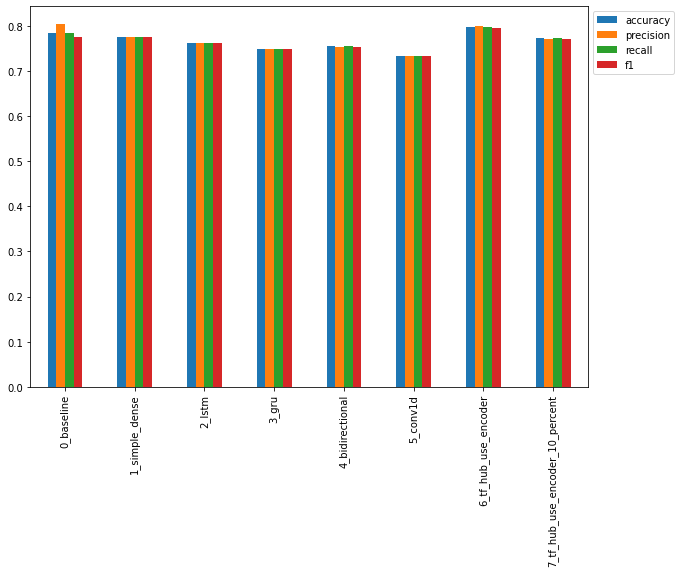

In [98]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

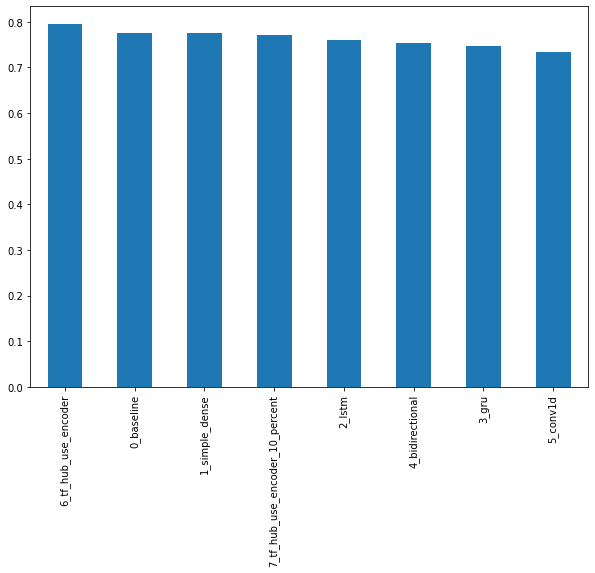

In [99]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar",figsize=(10, 7))

## Uploading our model training logs to TensorBoard.dev
we can further inspect our model's performance using TensorBoard.dev

In [ ]:
# View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs \
  --name "NLP Modelling Experiments ZTM TF Course Video" \
  --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
  --one_shot # exit the uploader once uploading finished

In [ ]:
# See previous TensorBoard dev experiments
!tensorboard dev list

Now I've ran the cell above, my modelling experiments can be viewed at
https://tensorboard.dev/experiment/5zrdsgkBTMuVdr282TQszA/#scalars

In [102]:
# If you need to delete an experiment from TensorBoard, you can run the following
#!tensorboard dev delete --experiment_id 5zrdsgkBTMuVdr282TQszA

> **Resource:** TensorBoard is great for quickly trachking experiments but for larger scale experiment tracking options, checkout Weights & Biases: https://wandb.ai/site

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SaveModel` format (this is the default when using TensorFlow

In [103]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("/content/drive/MyDrive/TensorFlow course/model_6.h5")

In [104]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("/content/drive/MyDrive/TensorFlow course/model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [105]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4379 - accuracy: 0.7966


[0.43794354796409607, 0.7965879440307617]

Now let's save to the `SavedModel` format

In [106]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("/content/drive/MyDrive/TensorFlow course/model_6_SavedModel_format")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow course/model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensorFlow course/model_6_SavedModel_format/assets


In [107]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("/content/drive/MyDrive/TensorFlow course/model_6_SavedModel_format")

In [108]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 19ms/step - loss: 0.4379 - accuracy: 0.7966


[0.43794354796409607, 0.7965879440307617]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those with prediction probabilities closest to the opposite class)

For exmample if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (close to 1) and vice versa.

In [109]:
# Download a pretrained model from Google storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2022-07-19 23:29:50--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 2607:f8b0:4023:c0d::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  72.3MB/s    in 16s     

2022-07-19 23:30:07 (57.6 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.index  
  inflat

In [110]:
# Import previously trained model from Google storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.3995 - accuracy: 0.8202


[0.3995266854763031, 0.8202099800109863]

In [111]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=float32)>

In [112]:
# Create DataFrame with validation sentences, validation labels and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,@DavidJordan88 @Stephanenny Except we don't kn...,1,0.0,0.389180
1,@SlopeOfHope Maybe the plan is to dilute until...,0,0.0,0.334284
2,.@bigperm28 was drafted by the @Avalanche in 2...,0,0.0,0.120673
3,That was crushed holy shit,0,0.0,0.135224
4,@tiggr_ why only Squad Obliteration?,1,0.0,0.168085


In [113]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong.head(10)

,text,target,pred,pred_prob
517,@TwopTwips make natural disaster reporting mor...,0,1.0,0.889624
743,One thing for sure-God has promised Israel wil...,0,1.0,0.878904
116,Governor weighs parole for California school b...,0,1.0,0.856527
690,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
310,Upheaval high note for bush opera http://t.co/...,0,1.0,0.808524
264,New doco tonight at 9pm Setanta Sports Ireland...,0,1.0,0.806903
362,VIDEO: Slain Mexican Journalist Unknowingly Pr...,0,1.0,0.796248
453,Alaska's #Wolves face catastrophe Denali Wolve...,0,1.0,0.779975
745,I hate this damn Milwaukee IndyFest. All the c...,0,1.0,0.730206
234,GENERAL AUDIENCE: On Wounded Families | ZENIT ...,0,1.0,0.716756


Let's remind ourselves of the target labels...
* `0` = not disaster
* `1` = disaster

In [114]:
most_wrong.tail(10)

,text,target,pred,pred_prob
245,@Zak_Bagans this is Sabrina my dad rescued her...,1,0.0,0.092346
179,If you're in search of powerful content to imp...,1,0.0,0.092099
729,@allen_enbot If you mess up it's gonna explode...,1,0.0,0.083298
7,Can't watch PVRIS I'm so sad bc it collided wi...,1,0.0,0.077123
657,@reriellechan HE WAS THE LICH KING'S FIRST CAS...,1,0.0,0.071257
609,@gilderoy i wish i was good enough to add flam...,1,0.0,0.071015
281,my dad said I look thinner than usual but real...,1,0.0,0.067040
707,Even if u have your weapon and your badge we g...,1,0.0,0.064087
627,Oh the usual. Mass murder and world domination...,1,0.0,0.036498
701,ÛÏ@LordBrathwaite: Everyone Here: Ahh I hate ...,1,0.0,0.031670


In [115]:
# Check the false positive (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.8896239399909973
Text:
@TwopTwips make natural disaster reporting more interesting by adding 'The' to headlines such as 'Rescuers are sifting through the wreckage'

----

Target: 0, Pred: 1.0, Prob: 0.8789042234420776
Text:
One thing for sure-God has promised Israel will not be annihilated. But...the horror of Iran w/nukes. https://t.co/xn09Mx6sxy

----

Target: 0, Pred: 1.0, Prob: 0.8565273284912109
Text:
Governor weighs parole for California school bus hijacker http://t.co/7NPBfRzEJL http://t.co/Y0kByy8nce

----

Target: 0, Pred: 1.0, Prob: 0.8108397126197815
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1.0, Prob: 0.8085242509841919
Text:
Upheaval high note for bush opera http://t.co/aWPU0gaE0b #Sydney #News #Aus

----

Target: 0, Pred: 1.0, Prob: 0.8069027662277222
Text:
New doco tonight at 9pm Setanta Sports Ireland freeview. The largest police 

In [116]:
# Check the false negative (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.09234565496444702
Text:
@Zak_Bagans this is Sabrina my dad rescued her from some dude who kept her in a cage. We've had her since I was 4 http://t.co/1k2PhQcuW8

----

Target: 1, Pred: 0.0, Prob: 0.0920991599559784
Text:
If you're in search of powerful content to improve your business or have been frustrated with the deluge of 'quantitÛ_https://t.co/64cyMG1lTG

----

Target: 1, Pred: 0.0, Prob: 0.08329841494560242
Text:
@allen_enbot If you mess up it's gonna explode...

----

Target: 1, Pred: 0.0, Prob: 0.07712289690971375
Text:
Can't watch PVRIS I'm so sad bc it collided with another set

----

Target: 1, Pred: 0.0, Prob: 0.07125729322433472
Text:
@reriellechan HE WAS THE LICH KING'S FIRST CASUALTY BLOCK ME BACK I HATE YOU! http://t.co/0Gidg9U45J

----

Target: 1, Pred: 0.0, Prob: 0.0710153579711914
Text:
@gilderoy i wish i was good enough to add flames to my nails im on fire

----

Target: 1, Pred: 0.0, Prob: 0.06703957915306091
Text:
my dad said I look

## Making predictions on the test dataset

In [117]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))  # our model 
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

Pred: 0, Prob: 0.05554637312889099
Text:
Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/aXqgUKn8Yz http://t.co/P1USSSv5Wa

----

Pred: 1, Prob: 0.9833022356033325
Text:
Sinjar Massacre Yazidis Blast Lack of Action Over Hostages http://t.co/fdU8aCnC2W #denver #billings #rapidcity #seattle #cheyenne #lasvegas

----

Pred: 0, Prob: 0.04048547148704529
Text:
@40URTY @DonOf_NikeTown snowstorm is my fave episode lmao

----

Pred: 1, Prob: 0.8571507930755615
Text:
Tractor-trailers collide on NJ Turnpike å_ 42 http://t.co/OTEXyh79J8 http://t.co/MLZG4l0xnL

----

Pred: 0, Prob: 0.37880223989486694
Text:
@RazeD_ yea in this photo

----

Pred: 0, Prob: 0.21771332621574402
Text:
@deray @marstu67 Cop Benefits:Great Salary Free Car Free Rent Free Food.Free Weapons License to Kill &amp; Rape with Impunity.

----

Pred: 1, Prob: 0.5906194448471069
Text:
Damn dry desert forest fire...damn :( https://t.co/P5SoDrkVW3

----

Pred: 1, Prob: 0.9064354

## Your challenge... predicting on Tweets from the wild

Go to your favourite Twitter account and copy one of their latest Tweets
Then pass that Tweet through our trained model.
Is that Tweet a disaster or not disaster ? is the model right or wrong?

In [118]:
test_sample="is this really a disaster? No, it is not!"
pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))  # our model 
pred = tf.round(pred_prob)
print(f"Pred: {int(pred)}, Prob: {pred_prob}")
print(f"Text:\n{test_sample}\n")
print("----\n")

Pred: 0, Prob: 0.3488229513168335
Text:
is this really a disaster? No, it is not!

----



In [119]:
test_sample="A hurricane is sweeping through Seoul today!"
pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))  # our model 
pred = tf.round(pred_prob)
print(f"Pred: {int(pred)}, Prob: {pred_prob}")
print(f"Text:\n{test_sample}\n")
print("----\n")

Pred: 1, Prob: 0.913348913192749
Text:
A hurricane is sweeping through Seoul today!

----



In [120]:
test_sample="This is a real disaster! We lost our match against Suewon!"
pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))  # our model 
pred = tf.round(pred_prob)
print(f"Pred: {int(pred)}, Prob: {pred_prob}")
print(f"Text:\n{test_sample}\n")
print("----\n")

Pred: 0, Prob: 0.4751460552215576
Text:
This is a real disaster! We lost our match against Suewon!

----



## The speed/score tradeoff

In [121]:
model_6_results

{'accuracy': 79.65879265091863,
 'f1': 0.7942331441856619,
 'precision': 0.7987320349567643,
 'recall': 0.7965879265091863}

In [122]:
baseline_results

{'accuracy': 78.34645669291339,
 'f1': 0.7750816117942654,
 'precision': 0.8028871176572036,
 'recall': 0.7834645669291339}

In [123]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predicttions on samples
  """
  start_time = time.perf_counter()  # get start time
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time # calculate how long predictions taken to make
  time_per_pred = total_time / len(samples)

  return total_time, time_per_pred

In [124]:
# Calculate model 6 time
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.2852373250000255, 0.00037432719816276314)

In [125]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0,
                                                              samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.038925748999986354, 5.108366010496897e-05)

In [126]:
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 82.02099737532808,
 'f1': 0.8182454651672169,
 'precision': 0.8227780174738433,
 'recall': 0.8202099737532809}

Text(0, 0.5, 'F1-score')

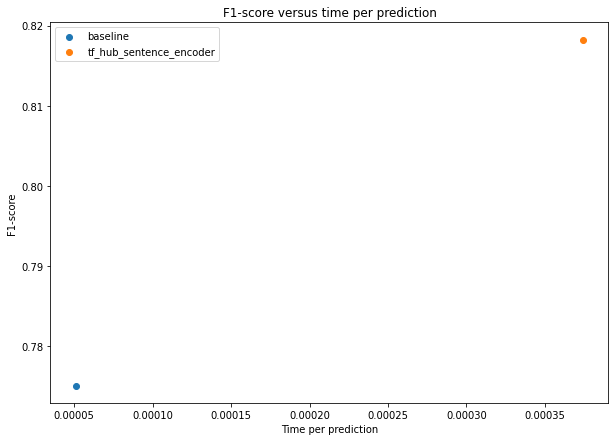

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")

## Excercises

### Build model 1, 2, 5 using Keras Sequential model

Model 1: simple dense model

In [128]:
# Model 1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers

model_1x = Sequential([
  keras.Input(shape=(1,), dtype=tf.string),
  text_vectorizer,
  embedding,
  layers.GlobalAveragePooling1D(),
  layers.Dense(1, activation="sigmoid")
],name="model_1_with_Sequential")

model_1x.summary()

Model: "model_1_with_Sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [129]:
# Compile the model
model_1x.compile(loss="binary_crossentropy",
                 optimizer=keras.optimizers.Adam(),
                 metrics=["accuracy"])

In [130]:

# Fit the model
model_1x_history = model_1x.fit(x=train_sentences,
                                y=train_labels,
                                epochs=5,
                                validation_data=(val_sentences, val_labels),
                                callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                       experiment_name="model_1x_dense")])

Saving TensorBoard log files to: model_logs/model_1x_dense/20220719-233036
Epoch 1/5
215/215 [==============================] - 4s 16ms/step - loss: 0.4662 - accuracy: 0.8986 - val_loss: 0.4950 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2748 - accuracy: 0.9267 - val_loss: 0.4733 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2026 - accuracy: 0.9418 - val_loss: 0.4859 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1626 - accuracy: 0.9558 - val_loss: 0.5125 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1367 - accuracy: 0.9635 - val_loss: 0.5463 - val_accuracy: 0.7664


In [131]:
# Check the results
model_1x.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.5463 - accuracy: 0.7664


[0.5462902784347534, 0.7664042115211487]

In [132]:
# Make predictions
model_1x_pred_probs = model_1x.predict(val_sentences)
model_1x_pred_probs[:5]

array([[0.01348764],
       [0.22399712],
       [0.25013173],
       [0.6041444 ],
       [0.11784431]], dtype=float32)

In [133]:
# Convert to label format
model_1x_preds = tf.squeeze(tf.round(model_1x_pred_probs))
model_1x_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 1., 0.], dtype=float32)>

In [134]:
# Calculate model 1x results
model_1x_results = calculate_results(y_true=val_labels,
                                     y_pred=model_1x_preds)
model_1x_results

{'accuracy': 76.64041994750657,
 'f1': 0.7660201893659146,
 'precision': 0.7659025055163764,
 'recall': 0.7664041994750657}

Model 2: LSTM model

In [135]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

model_2x = Sequential([
  keras.Input(shape=(1,), dtype="string"),
  text_vectorizer,
  embedding,
  layers.LSTM(64),
  layers.Dense(1, activation="sigmoid")                       
], name="model_2x_LSTM")

model_2x.summary()

Model: "model_2x_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [136]:
# Compile the model
model_2x.compile(loss="binary_crossentropy",
                 optimizer=keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model
model_2x.fit(train_sentences,
             train_labels,
             epochs=5,
             validation_data=(val_sentences, val_labels),
             callbacks=[create_tensorboard_callback(SAVE_DIR,"model_2x_LSTM")])

Saving TensorBoard log files to: model_logs/model_2x_LSTM/20220719-233054
Epoch 1/5
215/215 [==============================] - 10s 37ms/step - loss: 0.1092 - accuracy: 0.9679 - val_loss: 0.8470 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0516 - accuracy: 0.9780 - val_loss: 1.3488 - val_accuracy: 0.7520
Epoch 3/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0438 - accuracy: 0.9807 - val_loss: 1.2834 - val_accuracy: 0.7546
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0410 - accuracy: 0.9818 - val_loss: 1.3158 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0426 - accuracy: 0.9803 - val_loss: 1.3321 - val_accuracy: 0.7572


In [137]:
# Make prediction and convert to labels
model_2x_pred_probs = model_2x.predict(val_sentences)
model_2x_preds = tf.squeeze(tf.round(model_2x_pred_probs))
model_2x_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 1., 0.], dtype=float32)>

In [138]:
# Calculate model 2x result
model_2x_results = calculate_results(y_true=val_labels,
                                     y_pred=model_2x_preds)
model_2x_results

{'accuracy': 75.7217847769029,
 'f1': 0.7561681427002203,
 'precision': 0.7565192376368745,
 'recall': 0.7572178477690289}

Model 5: Conv1D

In [139]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

model_5x = Sequential([
  keras.Input(shape=(1,), dtype="string"),
  text_vectorizer,
  embedding,
  layers.Conv1D(filters=64,
                kernel_size=5,
                activation="relu",
                padding="valid"),
  layers.GlobalMaxPooling1D(),
  layers.Dense(1, activation="sigmoid")                                       
], name="model_5x_Conv1D")

model_5x.summary()

Model: "model_5x_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,321,089
Trainable params: 1,321,089

In [140]:
# Compile the model
model_5x.compile(loss="binary_crossentropy",
                 optimizer=keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Fit the model
model_5x.fit(train_sentences,
             train_labels,
             epochs=5,
             validation_data=(val_sentences, val_labels),
             callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1Dx")])

Saving TensorBoard log files to: model_logs/Conv1Dx/20220719-233138
Epoch 1/5
215/215 [==============================] - 5s 20ms/step - loss: 0.0974 - accuracy: 0.9660 - val_loss: 1.0065 - val_accuracy: 0.7428
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0621 - accuracy: 0.9769 - val_loss: 1.1580 - val_accuracy: 0.7388
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0518 - accuracy: 0.9791 - val_loss: 1.2479 - val_accuracy: 0.7375
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0479 - accuracy: 0.9806 - val_loss: 1.3714 - val_accuracy: 0.7375
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0483 - accuracy: 0.9806 - val_loss: 1.3633 - val_accuracy: 0.7402


In [141]:
# Make predictions and create labels
model_5x_pred_probs = model_5x.predict(val_sentences)
model_5x_preds = tf.squeeze(tf.round(model_5x_pred_probs))
model_5x_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 1., 0.], dtype=float32)>

In [142]:
# Calculate model 5x result
model_5x_results = calculate_results(y_true=val_labels,
                                     y_pred=model_5x_preds)
model_5x_results

{'accuracy': 74.01574803149606,
 'f1': 0.7396336372714326,
 'precision': 0.7394799313483473,
 'recall': 0.7401574803149606}

### Retrain baseline model with 10% of training data

In [143]:
# Get 10% data
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modeling pipeline
model_0x = Pipeline([
                     ("tfidf", TfidfVectorizer()),
                     ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0x.fit(train_sentences_10_percent, train_labels_10_percent)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [145]:
# Make predictions
model_0x_preds = model_0x.predict(val_sentences)

In [146]:
# Calculate the results
model_0x_results = calculate_results(y_true=val_labels,
                                     y_pred=model_0x_preds)
model_0x_results

{'accuracy': 74.93438320209974,
 'f1': 0.7357853653886128,
 'precision': 0.7756279495935398,
 'recall': 0.7493438320209974}

baseline model with 10% data is much less accurated than USE model with 10% data

### Fine-tuning the USE model with training = true

In [29]:
import tensorflow_hub as hub
import tensorflow as tf

# Create a Keras layers using the USE pretrained layer from tensorflow_hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True,
                                        name="USE")

In [30]:
from tensorflow.keras import layers

# Create the model using Sequential API
model_6x = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")                                
], name="model_6x_USE")

# Compile model
model_6x.compile(loss="binary_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 metrics=["accuracy"])

model_6x.summary()

Model: "model_6x_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Fit the model
model_6x_history = model_6x.fit(train_sentences,
                                train_labels,
                                epochs=4,
                                validation_data=(val_sentences,val_labels),
                                callbacks=[create_tensorboard_callback(SAVE_DIR,"tf_hub_sentence_encoderX")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoderX/20220720-233346
Epoch 1/4
215/215 [==============================] - 640s 3s/step - loss: 0.5856 - accuracy: 0.7244 - val_loss: 0.5105 - val_accuracy: 0.7717
Epoch 2/4
215/215 [==============================] - 585s 3s/step - loss: 0.4328 - accuracy: 0.8199 - val_loss: 0.4634 - val_accuracy: 0.7795
Epoch 3/4
215/215 [==============================] - 628s 3s/step - loss: 0.3602 - accuracy: 0.8518 - val_loss: 0.4526 - val_accuracy: 0.7913
Epoch 4/4
215/215 [==============================] - 794s 4s/step - loss: 0.2990 - accuracy: 0.8809 - val_loss: 0.4628 - val_accuracy: 0.7953


In [32]:
# Make a prediction and create label
model_6x_pred_probs = model_6x.predict(val_sentences)
model_6x_preds = tf.squeeze(tf.round(model_6x_pred_probs))
model_6x_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>

In [33]:
# Calculate the result
model_6x_results = calculate_results(y_true=val_labels,
                                     y_pred=model_6x_preds)
model_6x_results

{'accuracy': 79.52755905511812,
 'f1': 0.7939357578892172,
 'precision': 0.7954704045857961,
 'recall': 0.7952755905511811}

In [34]:
# Save this model
model_6x.save("/content/drive/MyDrive/TensorFlow course/model_6x.h5")

In [35]:
# Load the model 6x
import tensorflow_hub as hub
load_model_6x = tf.keras.models.load_model("/content/drive/MyDrive/TensorFlow course/model_6x.h5",
                                           custom_objects={"KerasLayer": hub.KerasLayer})

In [36]:
# Evaluate this model
load_model_6x.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 18ms/step - loss: 0.4628 - accuracy: 0.7953


[0.4627937972545624, 0.7952755689620972]

### Train the model on full dataset

In [30]:
train_sentences_full = train_df_shuffled["text"].to_numpy()
train_labels_full = train_df_shuffled["target"].to_numpy()

len(train_sentences_full), len(train_labels_full)

(7613, 7613)

In [31]:
# Train the model 6y on this data
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Create a Keras layers using the USE pretrained layer from tensorflow_hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype="string",
                                        trainable=True,
                                        name="USE")

# Create model using the Sequential API
model_6y = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")                                
], name="model_6y_USE")

# Compile the model
model_6y.compile(loss="binary_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 metrics=["accuracy"])

In [32]:
# # Fit the model
model_6y_history = model_6y.fit(train_sentences_full,
                                train_labels_full,
                                epochs=5)

Epoch 1/5
238/238 [==============================] - 854s 4s/step - loss: 0.5775 - accuracy: 0.7316
Epoch 2/5
238/238 [==============================] - 717s 3s/step - loss: 0.4263 - accuracy: 0.8185
Epoch 3/5
238/238 [==============================] - 730s 3s/step - loss: 0.3563 - accuracy: 0.8514
Epoch 4/5
238/238 [==============================] - 755s 3s/step - loss: 0.2887 - accuracy: 0.8851
Epoch 5/5
238/238 [==============================] - 792s 3s/step - loss: 0.2110 - accuracy: 0.9232


In [33]:
# Predict on the test data
test_sentences = test_df["text"].to_numpy()
len(test_sentences)

3263

In [35]:
# Make prediction
model_6y_pred_probs = model_6y.predict(test_sentences)
model_6y_preds = tf.squeeze(tf.round(model_6y_pred_probs))
model_6y_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [36]:
# Convert to numpy array
array = model_6y_preds.numpy()

# Numpy to pandas dataframe
import pandas as pd

# Dataframe to csv
df = pd.DataFrame(array)
df.to_csv("predict_data.csv")

In [37]:
# Download file
from google.colab import files
files.download("predict_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>